# Toggle-Frame Example Problem: Single Drive

This notebook illustrates the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors for a single pauli X drive and Hadamard as the unitary goal. It's strucuted as follows:
* Imports
* Problem Setup 
* Problem Solve
* Plot fidelity swept over additive & multiplicative error 
* Save trjaectories to file

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random

  Activating project at `~/Documents/GitHub/robust_control_sam/src`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Project.toml`
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Manifest.toml`


## Problem Setup

In [2]:
exp(- 1.0im * π * PAULIS.X / 4)

2×2 Matrix{ComplexF64}:
 0.707107+0.0im            0.0-0.707107im
      0.0-0.707107im  0.707107+0.0im

In [3]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = exp(- 1.0im * π * PAULIS.X / 4)
Δ = 0.0 # detuning
H_drift = Δ * PAULIS.Z
H_drive = PAULIS.X
a_bound = 1.0
dda_bound = 4.0
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drift, [H_drive])

QuantumSystem: levels = 2, n_drives = 1

In [4]:
sys.H.H_drives

1-element Vector{SparseMatrixCSC{ComplexF64, Int64}}:
 sparse([2, 1], [1, 2], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im], 2, 2)

In [5]:
# additive error Hamiltonian
Hₑ_add = a -> PAULIS.Z

# multiplicative error Hamiltonian
# X_drive = sys.H.H_drives[1]
# Hₑ_mult = a -> a[1] * X_drive

# no robustness
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(default, max_iter=200, print_level=5)

# additive robustness
add_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=1.0
        )
solve!(add_prob, max_iter=200, print_level=5)

# multiplicative robustness
# mult_prob = UnitarySmoothPulseProblem(
#     sys, U_goal, T, Δt;
#     piccolo_options=piccolo_opts,
#     activate_rob_loss=true,
#     H_err=Hₑ_mult,
#     Q_t=1.0
# )
# solve!(mult_prob, max_iter=200, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, runnin

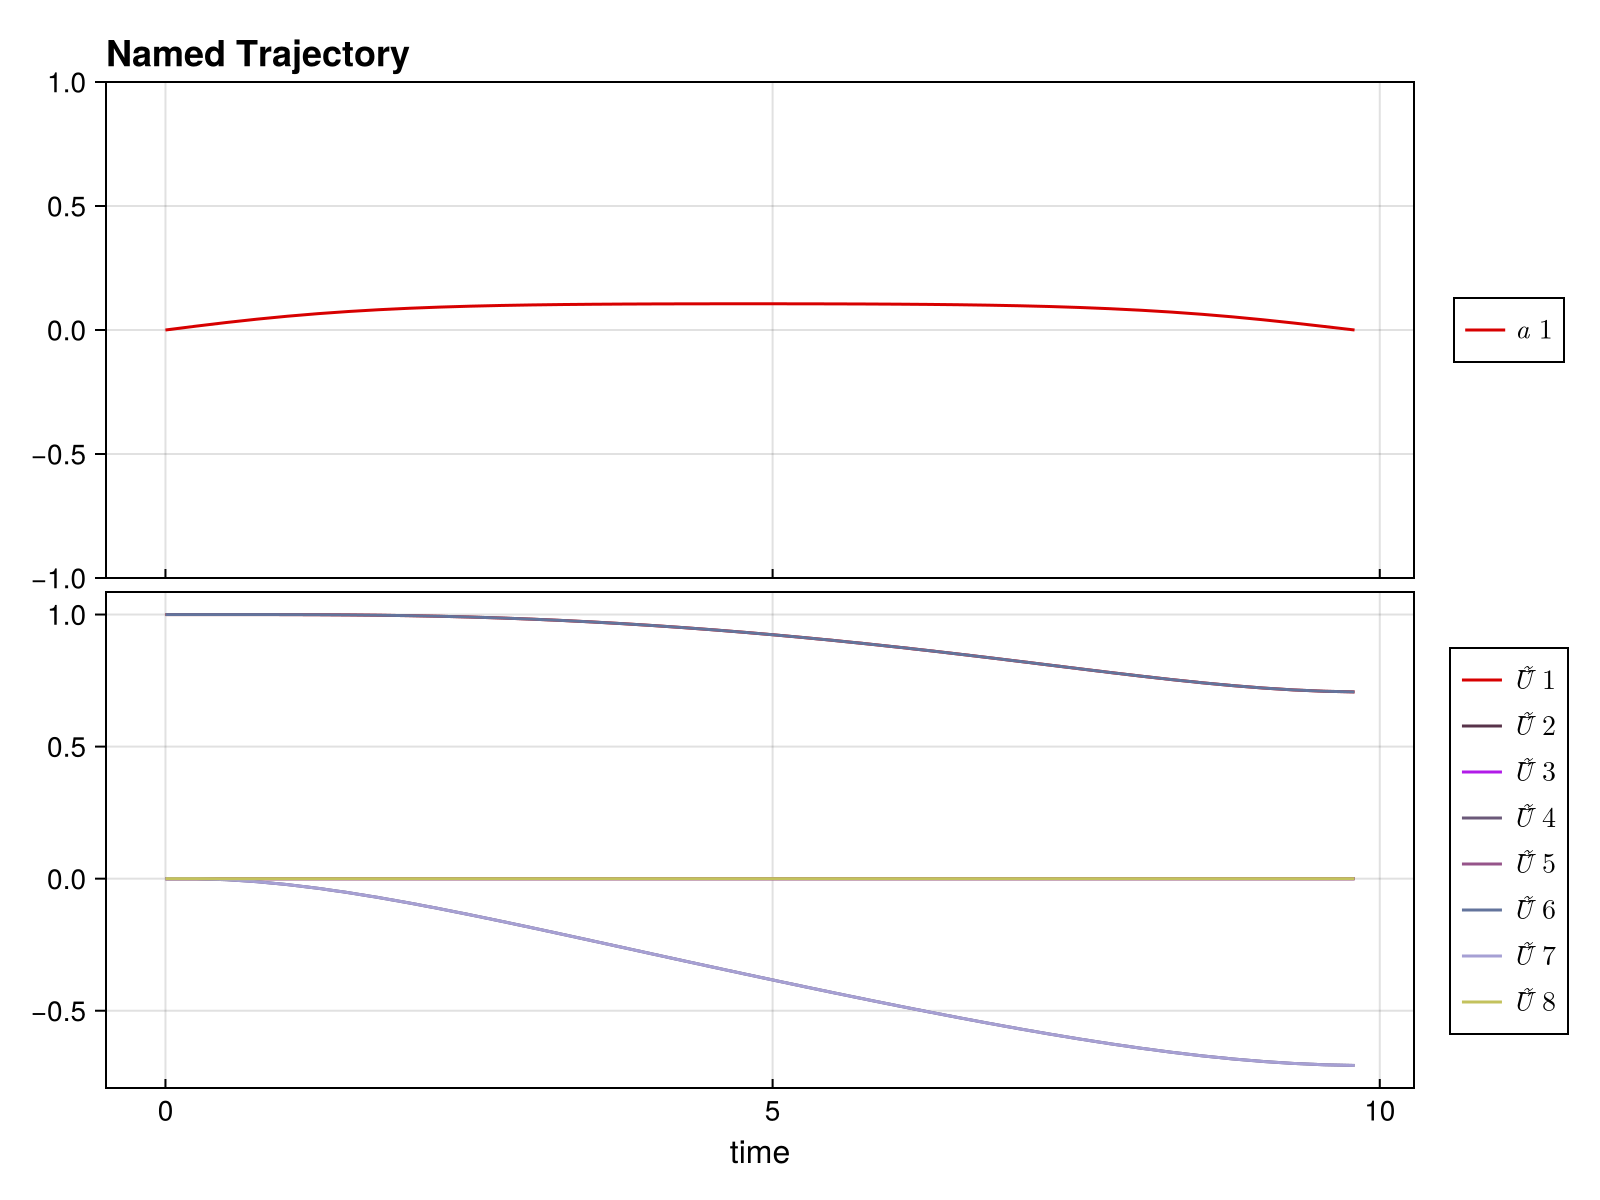

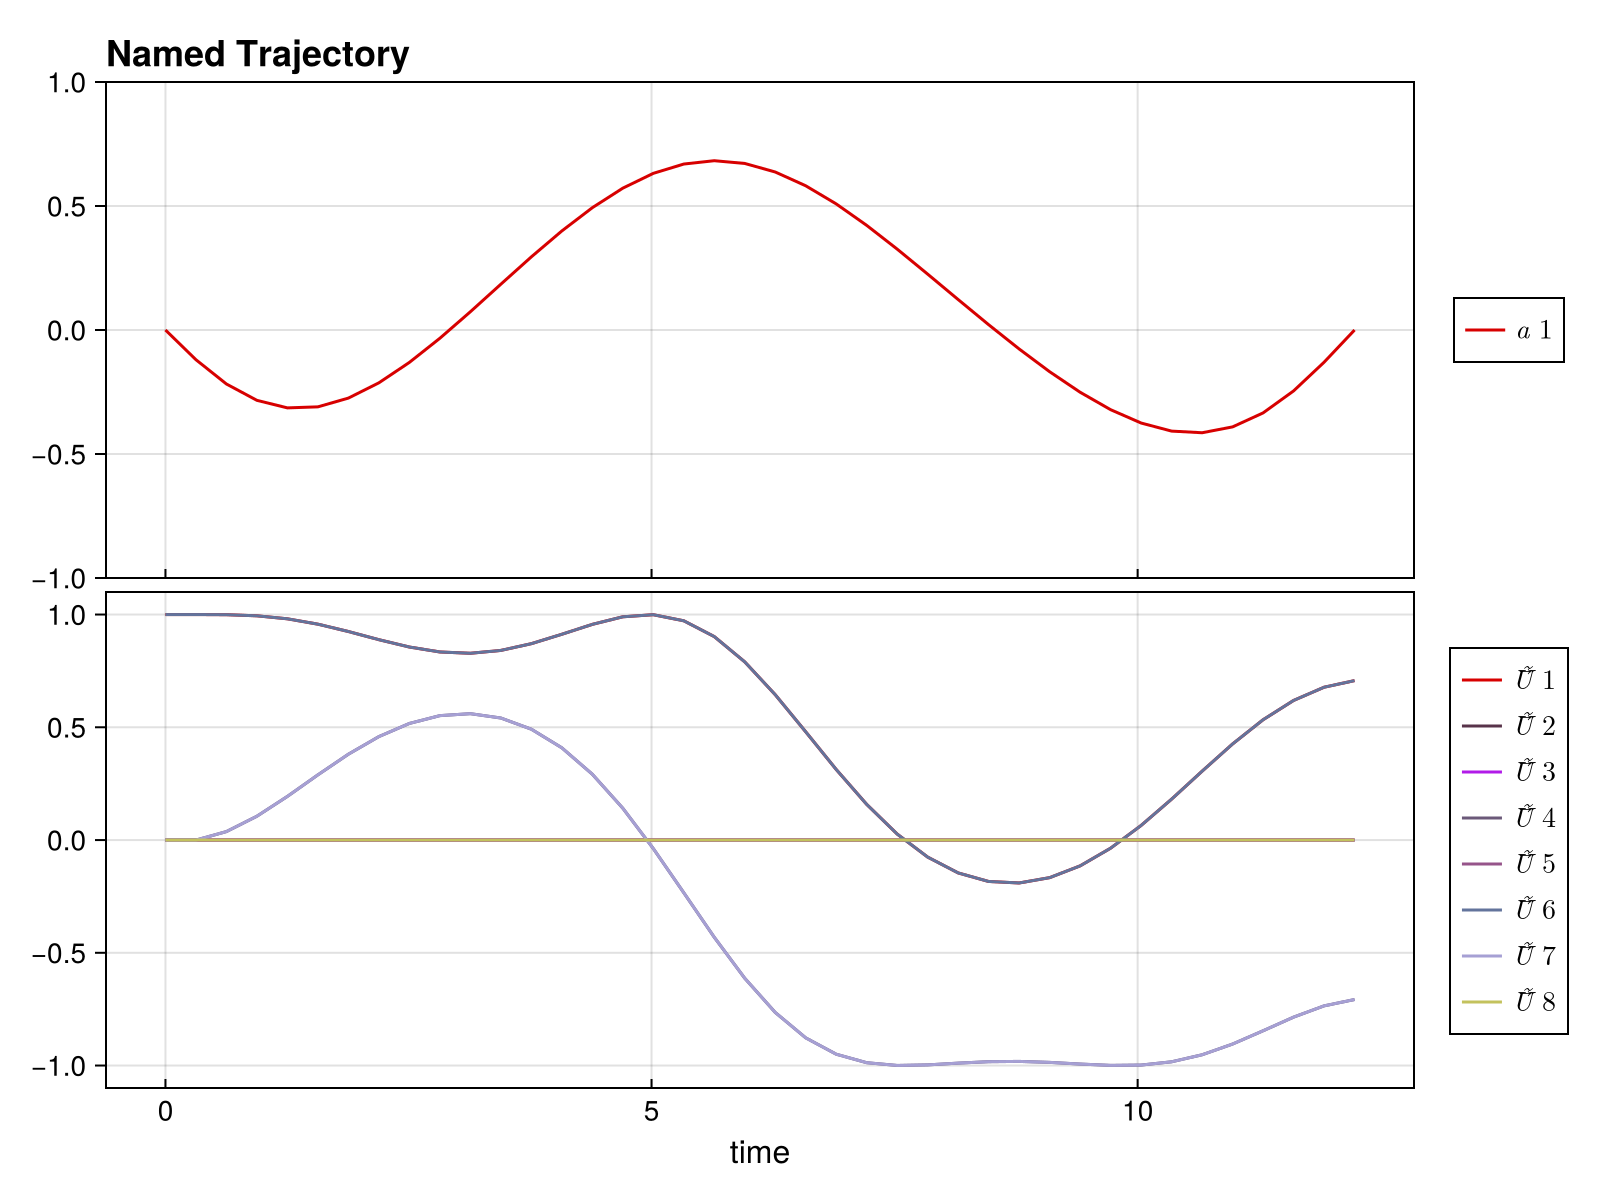

CairoMakie.Screen{IMAGE}


In [6]:
p1 = CairoMakie.plot(default.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
#p3 = CairoMakie.plot(mult_prob.trajectory, [:a, :Ũ⃗])

display(p1)
display(p2)
#display(p3)

#### Plotting

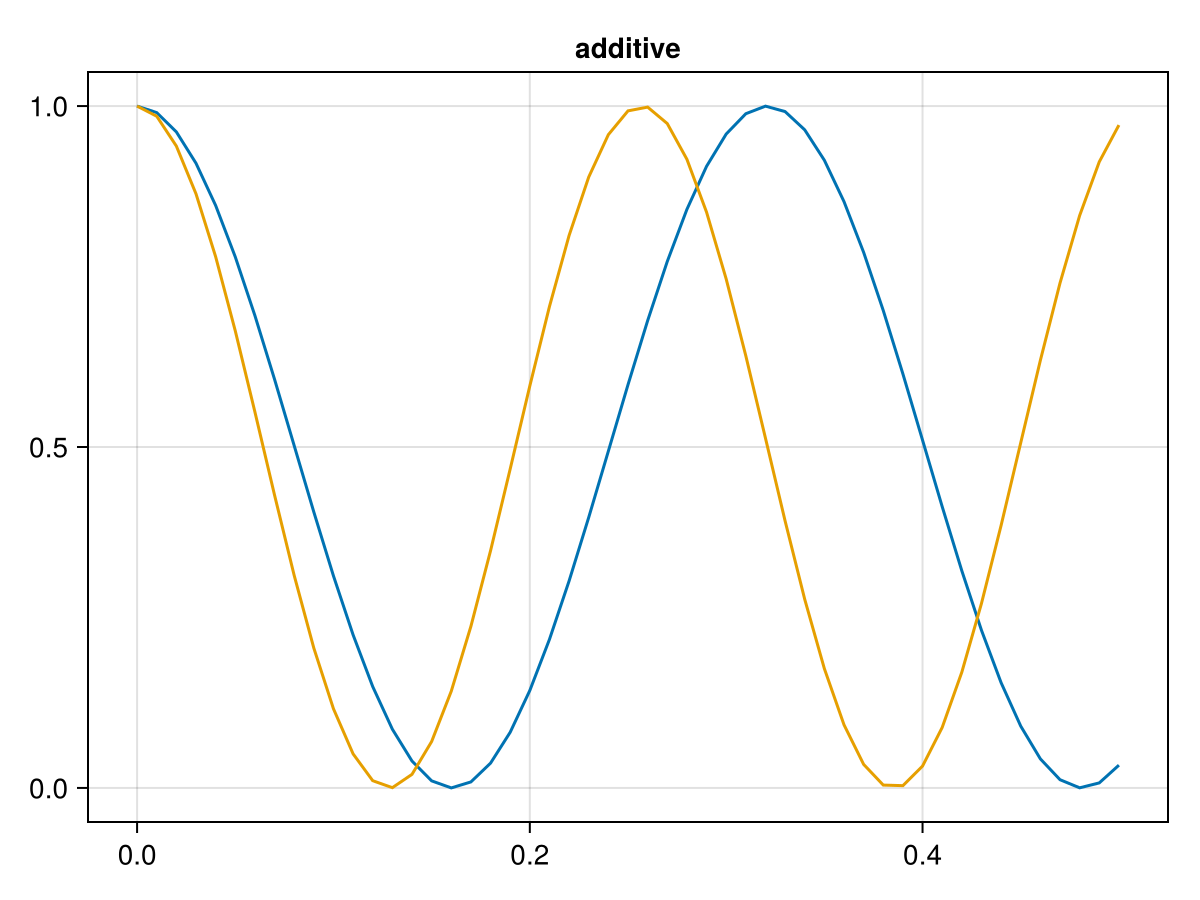

In [13]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
#ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

# ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
lines!(ax1, εs, ys, label="toggle", color=colors[2], linestyle=:solid)

# ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# (mult)
# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
# lines!(ax1, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

#Legend(f[1,1], ax1, position=:lb)
#Legend(f[2,2], ax2, position=:lb)

f


In [8]:
# ---------- Summary statistics ----------

# Helper to avoid division-by-zero in % improvement
safe_improvement(base, rob) = base == 0 ? 0.0 : (base - rob) / base * 100

# Build infidelity arrays over the same ε grid you defined earlier
# (Additive model: H = ε X + H_drift, drive = X)
additive_base_infids  = [1 - unitary_rollout_fidelity(default.trajectory,
                            QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
additive_robust_infids = [1 - unitary_rollout_fidelity(add_prob.trajectory,
                            QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
additive_improvements = [safe_improvement(additive_base_infids[i], additive_robust_infids[i])
                         for i in eachindex(additive_base_infids)]

# (Multiplicative model: H = H_drift, drive = (1+ε) X)
mult_base_infids  = [1 - unitary_rollout_fidelity(default.trajectory,
                        QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
mult_robust_infids = [1 - unitary_rollout_fidelity(mult_prob.trajectory,
                        QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
mult_improvements = [safe_improvement(mult_base_infids[i], mult_robust_infids[i])
                     for i in eachindex(mult_base_infids)]

error_magnitudes = collect(εs)

println("\nAdditive Error Results:")
println("Average base infidelity: $(round(mean(additive_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(additive_robust_infids), digits=4))")
println("Average improvement: $(round(mean(additive_improvements), digits=2))%")
println("Max improvement: $(round(maximum(additive_improvements), digits=2))%")

println("\nMultiplicative Error Results:")
println("Average base infidelity: $(round(mean(mult_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(mult_robust_infids), digits=4))")
println("Average improvement: $(round(mean(mult_improvements), digits=2))%")
println("Max improvement: $(round(maximum(mult_improvements), digits=2))%")

# Which error type benefits more?
avg_add_improvement = mean(additive_improvements)
avg_mult_improvement = mean(mult_improvements)

println("\nComparison:")
if avg_add_improvement > avg_mult_improvement
    println(" Additive errors benefit more from robust optimization")
    println("  Difference: $(round(avg_add_improvement - avg_mult_improvement, digits=2))% better")
elseif avg_mult_improvement > avg_add_improvement
    println(" Multiplicative errors benefit more from robust optimization")
    println("  Difference: $(round(avg_mult_improvement - avg_add_improvement, digits=2))% better")
else
    println(" Tie: both see the same average improvement")
end

println("\n Results Table:")
println("Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%")
println("-" ^ 75)
for i in eachindex(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | " *
            "$(lpad(round(additive_base_infids[i],  digits=4), 8)) | " *
            "$(lpad(round(additive_robust_infids[i], digits=4), 8)) | " *
            "$(lpad(round(additive_improvements[i], digits=1), 8)) | " *
            "$(lpad(round(mult_base_infids[i],     digits=4), 9)) | " *
            "$(lpad(round(mult_robust_infids[i],    digits=4), 8)) | " *
            "$(lpad(round(mult_improvements[i],    digits=1), 9))")
end


UndefVarError: UndefVarError: `mult_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Save Trajectory

In [9]:
using JLD2
using Dates

# Collect just the three trajectories from your problems
default_traj   = default.trajectory
add_traj       = add_prob.trajectory
mult_traj      = mult_prob.trajectory

# Optional: store both fidelity and infidelity traces used above
fid_traces = Dict(
    "εs" => error_magnitudes,
    # Additive
    "additive_base_infids"   => additive_base_infids,
    "additive_robust_infids" => additive_robust_infids,
    "additive_improvements"  => additive_improvements,
    # Multiplicative
    "mult_base_infids"       => mult_base_infids,
    "mult_robust_infids"     => mult_robust_infids,
    "mult_improvements"      => mult_improvements,
)

# Minimal metadata to reconstruct the setup
meta = Dict(
    "T"         => T,
    "Δt"        => Δt,
    "U_goal"    => U_goal,
    "a_bound"   => a_bound,
    "dda_bound" => dda_bound,
    "H_drift"   => H_drift,
    "H_drive"   => H_drive,
    "robust_opts" => Dict("Q_t" => 1.0,
                          "Hₑ_add" => "ε * X added to drift",
                          "Hₑ_mult" => "(1+ε) scaling of X drive")
)

# Save into artifacts/ with timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "single_run_trajectories_$(timestamp).jld2")

@info "Saving trajectories and traces to $outfile"
@save outfile default_traj add_traj mult_traj fid_traces meta
@info "Done. Saved keys: default_traj, add_traj, mult_traj, fid_traces, meta"


UndefVarError: UndefVarError: `mult_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
Vector{Matrix{ComplexF64}}(undef, T)

MethodError: MethodError: no method matching Vector{Matrix{ComplexF64}}(::Type{Matrix{ComplexF64}}, ::Int64)
The type `Vector{Matrix{ComplexF64}}` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  Vector{T}(!Matched::UndefInitializer, ::Int64) where T
   @ Core boot.jl:577
  Array{T, N}(!Matched::UndefInitializer, ::Int64...) where {T, N}
   @ Core boot.jl:587
  Vector{T}(!Matched::UndefInitializer, ::Integer) where T
   @ Base baseext.jl:23
  ...


In [108]:
add_prob.trajectory.T

40

In [ ]:
add_traj = add_prob.trajectory
default_traj = default.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * Hₑ * U
        first_order_terms[i] = first_order_integral
    end
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                    real(tr(PAULIS.Y * first_order_terms[t])),
                    real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 
    return space_curve
end



first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
first_order_integral = zeros(ComplexF64, size(U_goal))

Hₑ = PAULIS.Z

for i in 1:T
    U = iso_vec_to_operator(problem.trajectory.Ũ⃗[:, i])
    first_order_integral += U' * Hₑ * U
    first_order_terms[i] = first_order_integral
end
space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                real(tr(PAULIS.Y * first_order_terms[t])),
                real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 

40-element Vector{Vector{Float64}}:
 [0.0, 0.0, 2.0]
 [0.0, 0.0, 4.0]
 [0.0, -0.15021715634992236, 5.9943507229017]
 [0.0, -0.5706671070136998, 7.949656795870744]
 [0.0, -1.3305380474067192, 9.799682783243629]
 [0.0, -2.437783453679446, 11.465218015625997]
 [0.0, -3.845860838300427, 12.885541246074622]
 [0.0, -5.476499692864346, 14.043564098196237]
 [0.0, -7.246852569532725, 14.974075082622484]
 [0.0, -9.087444471854248, 15.756520894924375]
 ⋮
 [0.0, -11.12379285978624, 8.435367459078538]
 [0.0, -10.865543678577245, 6.45211070303176]
 [0.0, -10.15207679831838, 4.5836982724439075]
 [0.0, -8.989201130802423, 2.956516604064081]
 [0.0, -7.447266010477502, 1.6827677729578565]
 [0.0, -5.642383304647778, 0.821142321691412]
 [0.0, -3.697681043848789, 0.35409508964528713]
 [0.0, -1.7043373480147304, 0.19105855864985077]
 [0.0, 0.2956626482945077, 0.19093629568376752]

In [123]:
add_curve = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

40-element Vector{Vector{Float64}}:
 [0.0, 0.0, 2.0]
 [0.0, 0.0, 4.0]
 [-3.064889777262112e-248, 0.015572744495928095, 5.999939371488262]
 [-6.000046615839732e-248, 0.06149077752901158, 7.999412185567607]
 [-8.851799811670093e-248, 0.1512279290176543, 9.997397982224507]
 [-1.1717336908217544e-247, 0.29667529697826156, 11.992102236782895]
 [-1.4633736974395403e-247, 0.5080079989200483, 13.980905517424292]
 [-1.7594321811965316e-247, 0.7936577322888616, 15.960401470899905]
 [-2.0750046101443258e-247, 1.1603593496996207, 17.92649656620642]
 [-2.421545273761275e-247, 1.6132481633776603, 19.874544748989713]
 ⋮
 [1.925927377230662e-245, 31.965079078659244, 48.3862734947687]
 [3.3265379321523673e-245, 33.933933946542744, 48.737856357279725]
 [5.183872008154061e-245, 35.915273249082176, 49.010426656858655]
 [7.518758082230408e-245, 37.90519141984306, 49.210990047525215]
 [1.0326407701937218e-244, 39.90048151023549, 49.34816677726375]
 [1.3937190168620455e-244, 41.898715698909314, 49.4321913404

In [139]:
default_curve[1]

3-element Vector{Float64}:
 0.0
 0.0
 2.0

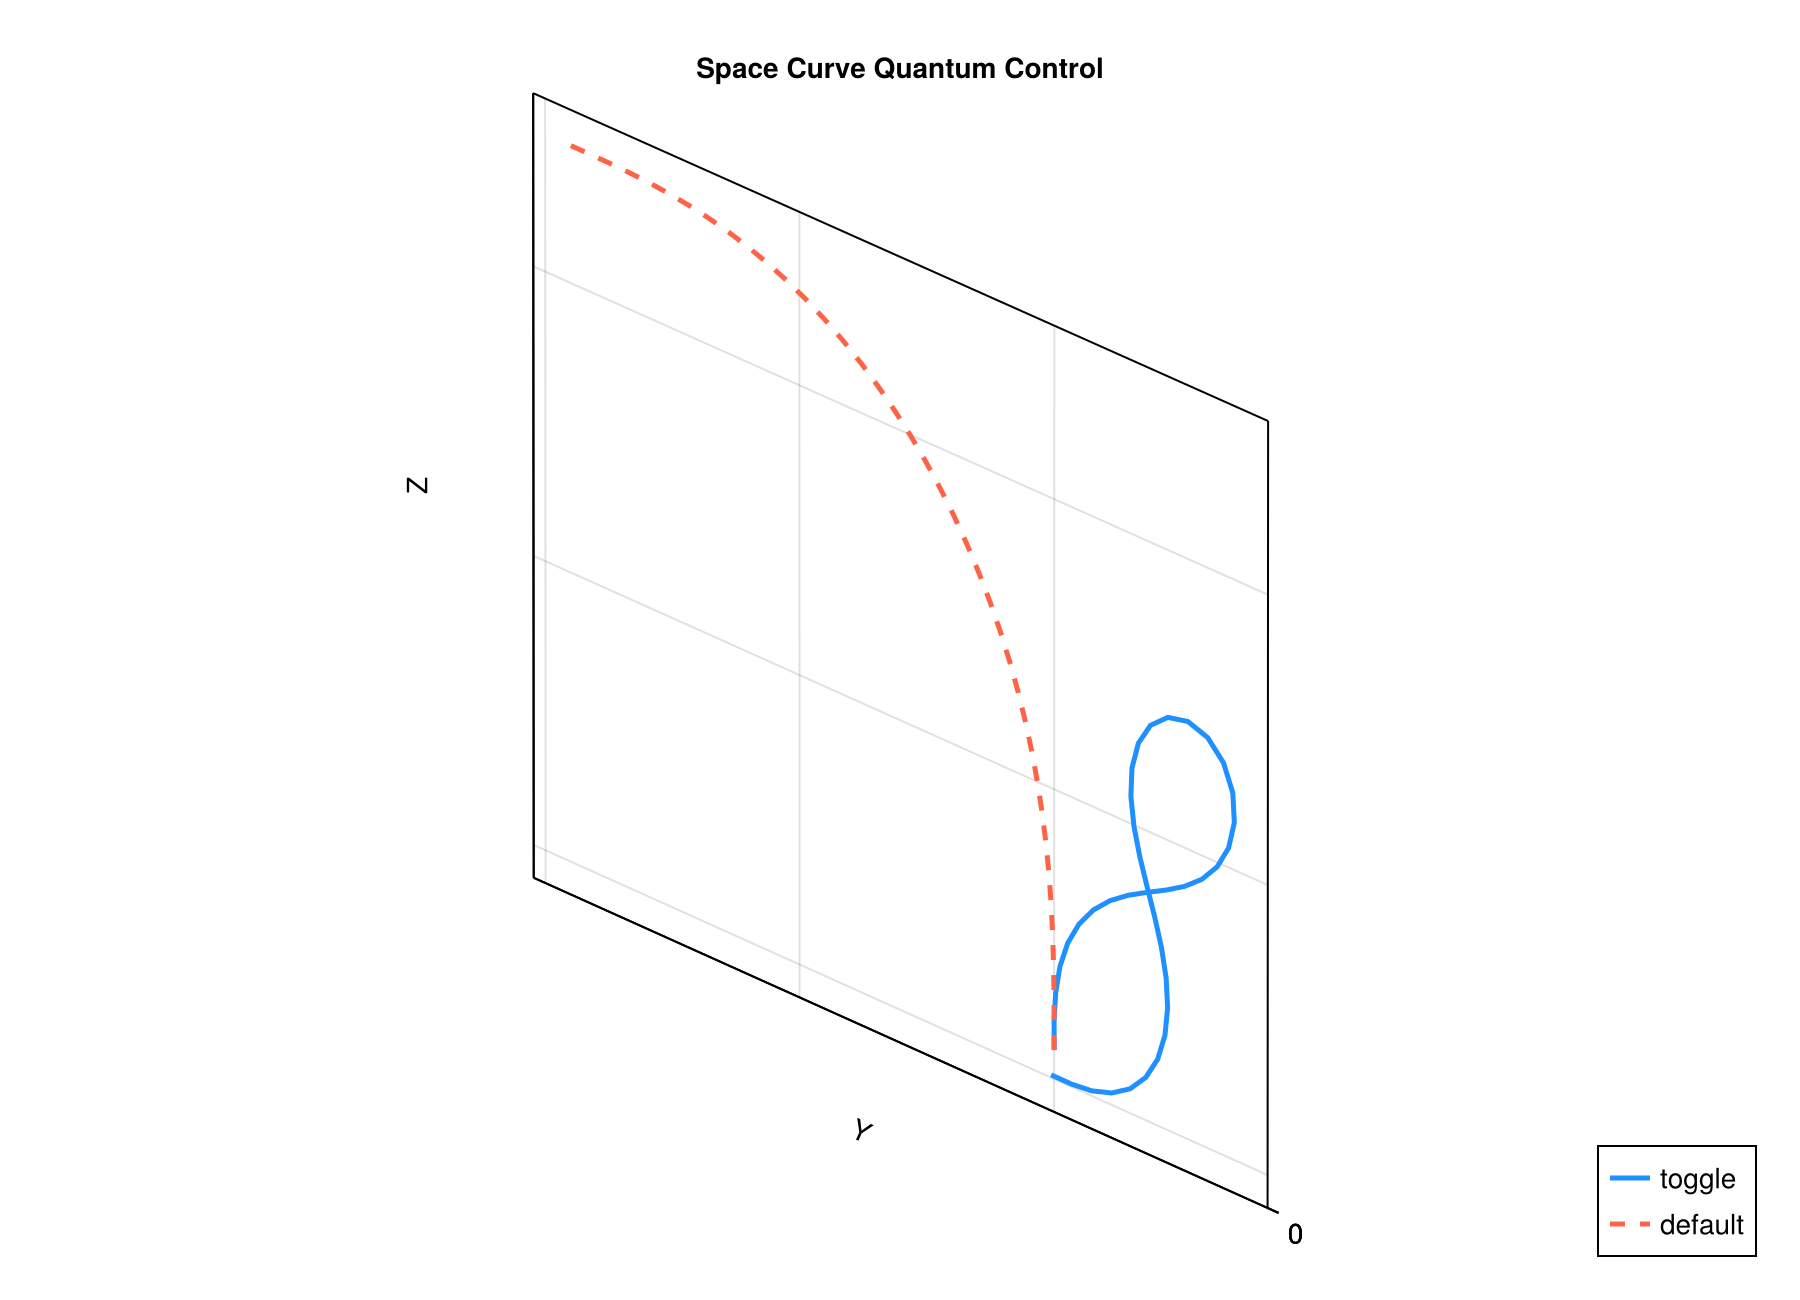

CairoMakie.Screen{IMAGE}


In [148]:
using CairoMakie
const CM = CairoMakie

# Coerce any reasonable "curve" into three Float64 vectors (x,y,z)
function to_xyz(curve)
    # Matrix cases: T×3 or 3×T
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        # Vector of 3-tuples / 3-vectors / SVectors
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    # Drop any non-finite points
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

# --- your data ---------------------------------------------------------------
add_curve     = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x1, y1, z1 = to_xyz(add_curve)
x2, y2, z2 = to_xyz(default_curve)

# --- plot --------------------------------------------------------------------
f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "toggle")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")

# Start/end markers so both are visible even if paths overlap
CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)

CM.axislegend(ax; position = :rb)

display(f)                 # ensure it shows in your environment


In [69]:
first_order_vec[40]

2×2 Matrix{ComplexF64}:
 0.707085+0.0im            0.0-0.707128im
      0.0-0.707128im  0.707085+0.0im

In [36]:
PAULIS.X * PAULIS.X 

2×2 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im

In [11]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs add_traj mult_traj fid_traces meta
